In [ ]:
import os.path as osp
import time

import torch
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import GraphSAGE

import importlib

import training
importlib.reload(training)
import graph_vis
importlib.reload(graph_vis)
import graph_creation
importlib.reload(graph_creation)
import utils
importlib.reload(utils)

In [ ]:
data = training.load_dataset_cora()


Processing...
Done!


In [3]:
train_loader = LinkNeighborLoader(
    data,
    batch_size=256,
    shuffle=True,
    neg_sampling_ratio=1.0,
    num_neighbors=[20, 20],
)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch_geometric.is_xpu_available():
    device = torch.device('xpu')
else:
    print('No GPU/TPU found. Using CPU instead.')
    device = torch.device('cpu')

data = data.to(device, 'x', 'edge_index', 'val_mask', 'test_mask')

# TODO: agg = 'mean'/'max'/'lstm'     ?:agg = 'pool', agg = 'gcn'

No GPU/TPU found. Using CPU instead.


In [4]:
def train(model):
    model.train()

    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        h = model(batch.x, batch.edge_index)
        h_src = h[batch.edge_label_index[0]]
        h_dst = h[batch.edge_label_index[1]]
        pred = (h_src * h_dst).sum(dim=-1)
        loss = F.binary_cross_entropy_with_logits(pred, batch.edge_label)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.size(0)

    return total_loss / data.num_nodes


@torch.no_grad()
def test(model):
    model.eval()
    out = model(data.x, data.edge_index).cpu().numpy()  # Explicitly move out to CPU
    y = data.y.cpu().numpy()  # Explicitly move data.y to CPU

    train_mask = data.train_mask.cpu().numpy()
    val_mask = data.val_mask.cpu().numpy()
    test_mask = data.test_mask.cpu().numpy()

    clf = LogisticRegression()
    clf.fit(out[data.train_mask], y[data.train_mask])

    val_acc = clf.score(out[val_mask], y[val_mask])
    test_acc = clf.score(out[test_mask], y[test_mask])

    return val_acc, test_acc

In [5]:
# model = GraphSAGE(
#     data.num_node_features,
#     hidden_channels=64,
#     num_layers=2,
# ).to(device)

for i in ['mean','max','lstm']:
    # I should be able to use 'pool' and 'gcn' as well, but I don't know how to do that yet.
    # TODO: I should print out the model summary to see the parameters and layers. sageconv class ha aggr as a parameter
    model= GraphSAGE(
        data.num_node_features,
        hidden_channels=64,
        num_layers=2,
        aggr=i
    ).to(device)
    print(f"Using {i} aggregation")
    print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    times = []
    for epoch in range(1, 30):
        start = time.time()
        loss = train(model)
        val_acc, test_acc = test(model)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
            f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
        times.append(time.time() - start)
    print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Using mean aggregation
GraphSAGE(1433, 64, num_layers=2)
Epoch: 001, Loss: 4.9645, Val: 0.3180, Test: 0.3180
Epoch: 002, Loss: 4.4808, Val: 0.5780, Test: 0.5710
Epoch: 003, Loss: 4.0069, Val: 0.6260, Test: 0.6170
Epoch: 004, Loss: 3.8964, Val: 0.6260, Test: 0.6350
Epoch: 005, Loss: 3.8494, Val: 0.6300, Test: 0.6430
Epoch: 006, Loss: 3.6865, Val: 0.6340, Test: 0.6570
Epoch: 007, Loss: 3.6599, Val: 0.6180, Test: 0.6690
Epoch: 008, Loss: 3.5736, Val: 0.6320, Test: 0.6840
Epoch: 009, Loss: 3.4894, Val: 0.6460, Test: 0.6590
Epoch: 010, Loss: 3.4783, Val: 0.6820, Test: 0.7000
Epoch: 011, Loss: 3.4162, Val: 0.6860, Test: 0.6980
Epoch: 012, Loss: 3.4068, Val: 0.6840, Test: 0.7140
Epoch: 013, Loss: 3.3991, Val: 0.6560, Test: 0.7040
Epoch: 014, Loss: 3.3366, Val: 0.6960, Test: 0.7070
Epoch: 015, Loss: 3.4125, Val: 0.6780, Test: 0.7010
Epoch: 016, Loss: 3.3341, Val: 0.6900, Test: 0.7110
Epoch: 017, Loss: 3.3059, Val: 0.7020, Test: 0.7230
Epoch: 018, Loss: 3.3327, Val: 0.7200, Test: 0.7130
Epoch: 

KeyboardInterrupt: 

In [ ]:
model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculation
    final_embeddings = model(data.x, data.edge_index).cpu().numpy() # Get embeddings for all nodes and move to CPU/NumPy
print(f"Final node embeddings shape: {final_embeddings.shape}") # Print the shape of the final embeddings
print(f"Final node embeddings: {final_embeddings}") # Print the final node embeddings

Final node embeddings shape: (2708, 64)
Final node embeddings: [[-0.06545623 -0.3397841   0.03066561 ...  0.21845426 -0.44368574
  -0.25538242]
 [-0.5671866  -0.02032056 -0.03818078 ... -0.25304055 -0.0504195
  -0.36643696]
 [-0.36525404 -0.10442527 -0.12396038 ... -0.15249208 -0.2883592
  -0.07047778]
 ...
 [ 0.07743983  0.09153387  0.06887946 ... -0.08317021 -0.00783428
  -0.07062417]
 [-0.07708395 -0.41013515 -0.12838486 ...  0.04459596 -0.36541402
   0.23740315]
 [-0.1240799  -0.08394182 -0.09847657 ...  0.23699589 -0.391949
   0.31890592]]


TypeError: A single argument passed to legend() must be a list of labels, but found an Artist in there.

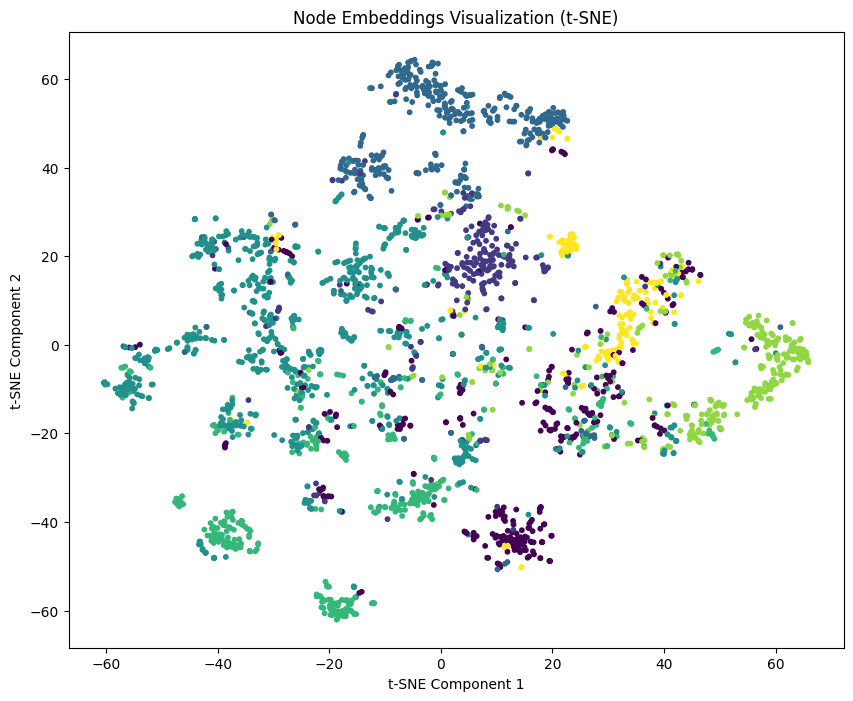

In [ ]:
# Get node labels for coloring
labels = data.y.cpu().numpy()

# 2. Apply t-SNE for Dimensionality Reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30) # You might need to tune perplexity
embeddings_2d = tsne.fit_transform(final_embeddings)

# 3. Visualize using Matplotlib
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', s=10) # Color by label
plt.title('Node Embeddings Visualization (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Create a legend (optional, but helpful)
# Get unique classes and their corresponding colors from the colormap
# classes = dataset.metadata[1]['classes'] # Get class names if available, otherwise use numbers
num_classes = dataset.num_classes
colors = plt.cm.viridis(torch.linspace(0, 1, num_classes))
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=5) for i in range(num_classes)]
plt.legend(handles, title="Classes") #classes

plt.show()